In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Data Split

In [2]:
df = pd.read_csv("nba_games.csv", index_col=0)

def add_won_next_game(group):
    group["Won Next"] = group["won"].shift(-1)
    return group

df = pd.read_csv("nba_games.csv", index_col=0)
df = df.sort_values("date").reset_index(drop=True).drop(['mp', 'mp.1', 'index_opp'], axis = 1)
df = df.groupby("team", group_keys=False).apply(add_won_next_game).dropna(subset=["Won Next"])
df[df['team'] == 'OKC']
nba_data = df
nba_data['Won Next'] = nba_data['Won Next'].astype(int)

nba_data.head()

fg   fga    fg%   3p   3pa    3p%    ft   fta    ft%   orb  ...  \
0  35.0  83.0  0.422  6.0  18.0  0.333  19.0  27.0  0.704   8.0  ...   
1  38.0  94.0  0.404  9.0  29.0  0.310  10.0  17.0  0.588  11.0  ...   
2  37.0  87.0  0.425  7.0  19.0  0.368  16.0  23.0  0.696   7.0  ...   
3  41.0  96.0  0.427  9.0  30.0  0.300  20.0  22.0  0.909  21.0  ...   
4  37.0  82.0  0.451  8.0  27.0  0.296  12.0  15.0  0.800   7.0  ...   

   usg%_max_opp  ortg_max_opp  drtg_max_opp  team_opp  total_opp  home_opp  \
0          43.7         206.0         104.0       GSW        111         1   
1          34.6         162.0         104.0       CHI         97         1   
2          29.0         138.0         105.0       CLE         95         0   
3          38.9         201.0         120.0       NOP         95         0   
4          23.6         132.0         104.0       DET        106         0   

   season        date    won  Won Next  
0    2016  2015-10-27  False         0  
1    2016  2015-10-27  False         1  
2    2016  2015-10-27   True         1  
3    2016  2015-10-27   True         1  
4    2016  2015-10-27  False         1  

[5 rows x 148 columns]

# Baseline (predict all 0 or 1)

In [3]:
zeros = np.zeros(len(nba_data['Won Next']))  #amount of 0s
zeros_accuracy = accuracy_score(nba_data['Won Next'], zeros)
print("Zeros Model Evaluation:", zeros_accuracy)

ones = np.ones(len(nba_data['Won Next']))  #amount of 1s
ones_accuracy = accuracy_score(nba_data['Won Next'], ones)
print("Ones Model Evaluation:", ones_accuracy)

Zeros Model Evaluation: 0.4999436365685943
Ones Model Evaluation: 0.5000563634314057


# Baseline (by better record)

In [4]:
nba_data['Won Next'] = nba_data['Won Next'].astype(int)

#total wins for each team
nba_data['total_wins'] = nba_data.groupby('team')['won'].cumsum() 

#total wins for opponent
nba_data['opp_wins'] = nba_data.apply(
    lambda row: nba_data[(nba_data['team'] == row['team_opp']) & 
                         (nba_data['season'] == row['season']) & 
                         (nba_data.index < row.name)]['won'].sum(), axis=1
)

In [5]:
#baseline pred
nba_data['baseline_prediction'] = (nba_data['total_wins'] > nba_data['opp_wins']).astype(int)

baseline_accuracy = accuracy_score(nba_data['Won Next'], nba_data['baseline_prediction'])
baseline_precision = precision_score(nba_data['Won Next'], nba_data['baseline_prediction'])
baseline_recall = recall_score(nba_data['Won Next'], nba_data['baseline_prediction'])
baseline_f1 = f1_score(nba_data['Won Next'], nba_data['baseline_prediction'])

print("Baseline Model Evaluation:")
print(f"Accuracy: {baseline_accuracy:.2f}")
print(f"Precision: {baseline_precision:.2f}")
print(f"Recall: {baseline_recall:.2f}")
print(f"F1-Score: {baseline_f1:.2f}")

Baseline Model Evaluation:
Accuracy: 0.51
Precision: 0.51
Recall: 0.93
F1-Score: 0.66


In [7]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(nba_data['Won Next'], nba_data['baseline_prediction'])

TN, FP, FN, TP = cm.ravel()
TPR = TP / (TP + FN) 
FPR = FP / (FP + TN)
Precision = TP / (TP + FP)

print(f"True Positive Rate (TPR): {TPR:.2f}")
print(f"False Positive Rate (FPR): {FPR:.2f}")
print(f"Precision: {Precision:.2f}")

True Positive Rate (TPR): 0.93
False Positive Rate (FPR): 0.91
Precision: 0.51


# RF Baseline

In [8]:
#choose features
selected_columns = ['team', 'team_opp', 'home_opp', 'season', 'won', 'Won Next']
nba_filtered_data = nba_data[selected_columns]

#One hot encode teams
label_encoder = LabelEncoder()
nba_filtered_data['team'] = label_encoder.fit_transform(nba_filtered_data['team'])
nba_filtered_data['team_opp'] = label_encoder.fit_transform(nba_filtered_data['team_opp'])

X = nba_filtered_data.drop(columns=['Won Next'])
y = label_encoder.fit_transform(nba_filtered_data['Won Next'])

y = df['Won Next'] 
encoder = LabelEncoder()
y = encoder.fit_transform(y)

#Split data into training and testing sets by season
train_seasons = [2016, 2017, 2018, 2019, 2020,2021]  
test_seasons = [2022] 

#training set
X_train = X[df['season'].isin(train_seasons)]
y_train = y[df['season'].isin(train_seasons)]

#test set
X_test = X[df['season'].isin(test_seasons)]
y_test = y[df['season'].isin(test_seasons)]

#train RF
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, classification_report_output
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

/tmp/ipykernel_35/921938821.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_filtered_data['team'] = label_encoder.fit_transform(nba_filtered_data['team'])
/tmp/ipykernel_35/921938821.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_filtered_data['team_opp'] = label_encoder.fit_transform(nba_filtered_data['team_opp'])
Accuracy: 0.5198776758409785
Precision: 0.5192592592592593
Recall: 0.5359327217125383
F1-Score: 0.527464258841234


In [9]:
nulls = pd.isnull(df).sum()
nulls = nulls[nulls > 0]
valid_columns = df.columns[~df.columns.isin(nulls.index)]
valid_columns

Index(['fg', 'fga', 'fg%', '3p', '3pa', '3p%', 'ft', 'fta', 'ft%', 'orb',
       ...
       'team_opp', 'total_opp', 'home_opp', 'season', 'date', 'won',
       'Won Next', 'total_wins', 'opp_wins', 'baseline_prediction'],
      dtype='object', length=145)

In [10]:
from sklearn.feature_selection import VarianceThreshold

numerical_data = df.select_dtypes(include=['float64', 'int64'])

#Low Variance Filter
variance_threshold = 0.01  
selector = VarianceThreshold(threshold=variance_threshold)
filtered_data_low_variance = selector.fit_transform(numerical_data)

#cols being kept
retained_columns_variance = numerical_data.columns[selector.get_support()]

#High Correlation Filter
correlation_matrix_reduced = pd.DataFrame(filtered_data_low_variance, columns=retained_columns_variance).corr()

#filter out cols above threshold
threshold = 0.9  
to_drop = set()
for i in range(correlation_matrix_reduced.shape[0]):
    for j in range(i + 1, correlation_matrix_reduced.shape[1]):
        if abs(correlation_matrix_reduced.iloc[i, j]) > threshold:
            to_drop.add(correlation_matrix_reduced.columns[j])

#filter out cols
final_columns = [col for col in retained_columns_variance if col not in to_drop]

reduced_data = numerical_data[final_columns]

#remaining cols
final_columns

/root/venv/lib/python3.9/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


['fg',
 'fga',
 '3p',
 '3pa',
 'ft',
 'ft%',
 'orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',
 'drb%',
 'trb%',
 'ast%',
 'ortg',
 'drtg',
 'fg_max',
 'fga_max',
 'fg%_max',
 '3p_max',
 '3pa_max',
 '3p%_max',
 'ft_max',
 'orb_max',
 'drb_max',
 'trb_max',
 'ast_max',
 'stl_max',
 'blk_max',
 'tov_max',
 'pf_max',
 'pts_max',
 '+/-_max',
 'ts%_max',
 '3par_max',
 'ftr_max',
 'orb%_max',
 'drb%_max',
 'trb%_max',
 'ast%_max',
 'stl%_max',
 'blk%_max',
 'tov%_max',
 'usg%_max',
 'ortg_max',
 'home',
 'mp_opp',
 'fg_opp',
 'fga_opp',
 '3p_opp',
 '3pa_opp',
 'ft_opp',
 'ft%_opp',
 'drb_opp',
 'trb_opp',
 'ast_opp',
 'stl_opp',
 'blk_opp',
 'tov_opp',
 'pf_opp',
 'pts_opp',
 'ast%_opp',
 'fg_max_opp',
 'fga_max_opp',
 'fg%_max_opp',
 '3p_max_opp',
 '3pa_max_opp',
 '3p%_max_opp',
 'ft_max_opp',
 'orb_max_opp',
 'drb_max_opp',
 'trb_max_opp',
 'ast_max_opp',
 'stl_max_opp',
 'blk_max_opp',
 'tov_max_opp',
 'pf_max_opp',
 'pts_max_opp',
 '+/-_max_opp',
 'ts%_max_opp',
 '3p

In [11]:
#standardize data
scaler = StandardScaler()
final_columns.append('won')
final_columns.remove('season')
df[final_columns] = scaler.fit_transform(df[final_columns])
final_columns.append('season')
new_df = df[final_columns].copy()
new_df

fg       fga        3p       3pa        ft       ft%       orb  \
0     -0.948757 -0.555662 -1.267673 -1.618856  0.265002 -0.646104 -0.563913   
1     -0.374773  0.964717 -0.510263 -0.226759 -1.243176 -1.773112  0.242071   
2     -0.566101 -0.002797 -1.015203 -1.492301 -0.237724 -0.723828 -0.832574   
3      0.199211  1.241149 -0.510263 -0.100205  0.432577  1.345592  2.928682   
4     -0.566101 -0.693878 -0.762733 -0.479868 -0.908026  0.286593 -0.832574   
...         ...       ...       ...       ...       ...       ...       ...   
17765  0.581867  0.273636  0.499619  0.532566 -0.070149 -0.607241  1.316715   
17766  0.007883  0.550068  1.004559  1.545000 -0.908026  0.286593  1.585376   
17767 -1.140085 -0.279229  1.004559  0.912229 -0.572875 -0.325489  0.242071   
17768  0.199211  0.135419 -0.510263  1.165338 -0.740450  0.937537 -1.638557   
17769 -1.714070 -1.661391 -0.005322  0.152904  0.600152 -0.908425 -0.563913   

            drb       trb       ast  ...  blk%_max_opp  tov%_max_opp  \
0     -1.671141 -1.700801 -0.513159  ...     -0.165192      1.382286   
1      0.917663  0.895528  0.452832  ...      0.743557      0.618605   
2      1.102577  0.437353 -2.058745  ...      1.413946     -0.456205   
3      0.178004  1.811880  1.032427  ...     -0.403552     -0.121505   
4     -0.191825 -0.631724 -0.319961  ...     -0.641913     -0.319497   
...         ...       ...       ...  ...           ...           ...   
17765 -0.376739  0.437353  0.839229  ...      4.378555      2.824795   
17766  0.917663  1.659155 -0.706357  ...     -0.299270     -0.673053   
17767 -0.561654 -0.326274 -0.319961  ...      0.192349      0.133055   
17768  0.178004 -0.784449 -0.126763  ...      0.505197      0.232051   
17769  0.917663  0.437353 -1.092754  ...     -0.209885     -0.319497   

       usg%_max_opp  ortg_max_opp  Won Next  total_wins  opp_wins  \
0          1.038972      0.681888 -1.000113   -1.566741 -1.397066   
1         -0.030820     -0.396519  0.999887   -1.566741 -1.397066   
2         -0.689154     -0.984741  0.999887   -1.556287 -1.397066   
3          0.474686      0.559342  0.999887   -1.556287 -1.397066   
4         -1.323976     -1.131797  0.999887   -1.566741 -1.397066   
...             ...           ...       ...         ...       ...   
17765     -0.254184     -0.347500 -1.000113    2.541619  2.762503   
17766     -0.289452      0.657379  0.999887    3.001588  2.699479   
17767      0.169031     -1.107287 -1.000113    2.541619  2.825527   
17768      6.999245      2.985758  0.999887    3.012042  2.699479   
17769      0.157275      1.074036 -1.000113    2.541619  2.888551   

       baseline_prediction       won  season  
0                -3.407317 -1.001128    2016  
1                -3.407317 -1.001128    2016  
2                 0.293486  0.998873    2016  
3                 0.293486  0.998873    2016  
4                -3.407317 -1.001128    2016  
...                    ...       ...     ...  
17765             0.293486  0.998873    2022  
17766             0.293486  0.998873    2022  
17767             0.293486 -1.001128    2022  
17768             0.293486  0.998873    2022  
17769             0.293486 -1.001128    2022  

[17742 rows x 101 columns]

In [12]:
data2 = new_df
data2.head()

fg       fga        3p       3pa        ft       ft%       orb  \
0 -0.948757 -0.555662 -1.267673 -1.618856  0.265002 -0.646104 -0.563913   
1 -0.374773  0.964717 -0.510263 -0.226759 -1.243176 -1.773112  0.242071   
2 -0.566101 -0.002797 -1.015203 -1.492301 -0.237724 -0.723828 -0.832574   
3  0.199211  1.241149 -0.510263 -0.100205  0.432577  1.345592  2.928682   
4 -0.566101 -0.693878 -0.762733 -0.479868 -0.908026  0.286593 -0.832574   

        drb       trb       ast  ...  blk%_max_opp  tov%_max_opp  \
0 -1.671141 -1.700801 -0.513159  ...     -0.165192      1.382286   
1  0.917663  0.895528  0.452832  ...      0.743557      0.618605   
2  1.102577  0.437353 -2.058745  ...      1.413946     -0.456205   
3  0.178004  1.811880  1.032427  ...     -0.403552     -0.121505   
4 -0.191825 -0.631724 -0.319961  ...     -0.641913     -0.319497   

   usg%_max_opp  ortg_max_opp  Won Next  total_wins  opp_wins  \
0      1.038972      0.681888 -1.000113   -1.566741 -1.397066   
1     -0.030820     -0.396519  0.999887   -1.566741 -1.397066   
2     -0.689154     -0.984741  0.999887   -1.556287 -1.397066   
3      0.474686      0.559342  0.999887   -1.556287 -1.397066   
4     -1.323976     -1.131797  0.999887   -1.566741 -1.397066   

   baseline_prediction       won  season  
0            -3.407317 -1.001128    2016  
1            -3.407317 -1.001128    2016  
2             0.293486  0.998873    2016  
3             0.293486  0.998873    2016  
4            -3.407317 -1.001128    2016  

[5 rows x 101 columns]

In [13]:
#data preprocessing again
X = data2.drop(columns=['Won Next'])
y = LabelEncoder().fit_transform(data2['Won Next'])

y = data2['Won Next']  
encoder = LabelEncoder()
y = encoder.fit_transform(y)  

train_seasons = [2016, 2017, 2018, 2019, 2020,2021]  
test_seasons = [2022]  

#training set
X_train = X[data2['season'].isin(train_seasons)]
y_train = y[data2['season'].isin(train_seasons)]

#test set
X_test = X[data2['season'].isin(test_seasons)]
y_test = y[data2['season'].isin(test_seasons)]

X_train.drop('season', axis = 1)
X_test.drop('season', axis = 1)

#train RF
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

#output
accuracy, classification_report_output
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.5321100917431193
Precision: 0.5295774647887324
Recall: 0.5749235474006116
F1-Score: 0.5513196480938416


# Feature Importance Bar Plot 

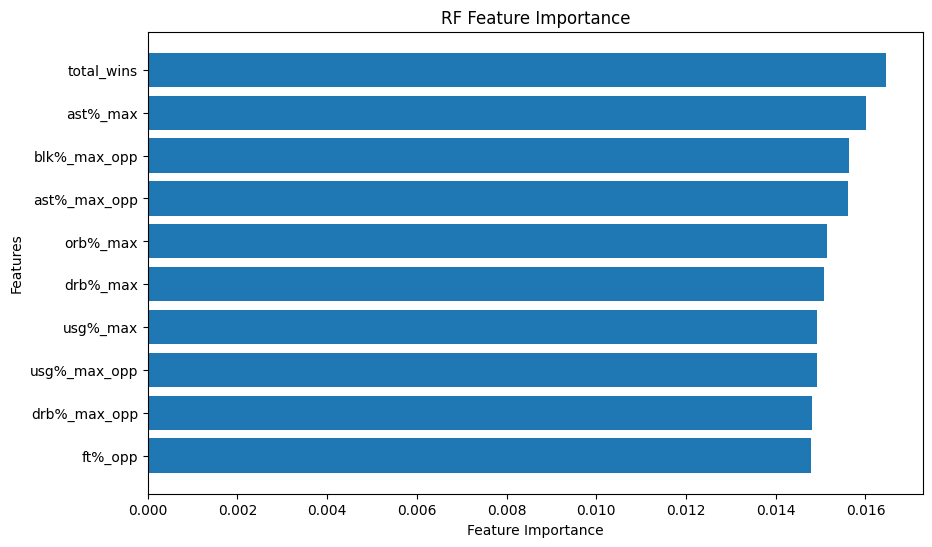

In [14]:
#find feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances = feature_importance['Importance']
feature_names = feature_importance['Feature']

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('RF Feature Importance')
plt.gca().invert_yaxis()
plt.show()


# Confusion Matrix

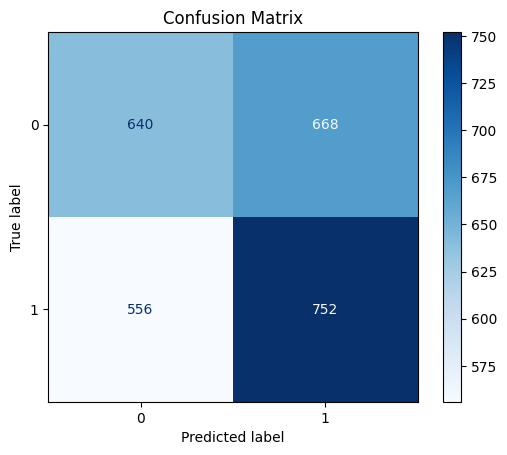

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = rf_model.predict(X_test)

ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


# ROC Curve

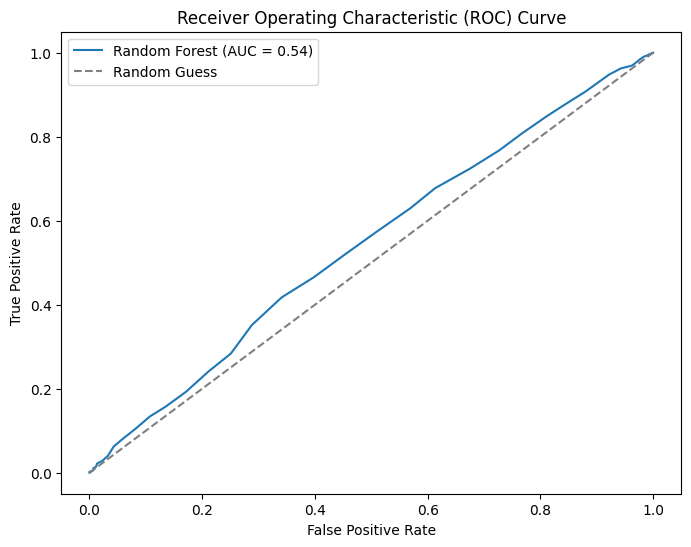

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score

#find pred probabilities
y_proba = rf_model.predict_proba(X_test)[:, 1]

#calculate auc 
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# TPR & FPR Calculation

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

TN, FP, FN, TP = cm.ravel()

TPR = TP / (TP + FN) 
FPR = FP / (FP + TN)
Precision = TP / (TP + FP)

# Print metrics
print(f"True Positive Rate (TPR): {TPR:.2f}")
print(f"False Positive Rate (FPR): {FPR:.2f}")
print(f"Precision: {Precision:.2f}")

True Positive Rate (TPR): 0.57
False Positive Rate (FPR): 0.51
Precision: 0.53
